## Running compressed variational quantum eigensolvers

cVQE provides classes to run variational quantum eigensolvers in compressed space. This notebook shows how to use the package to run compressed algorithms within Qiskit.

To run a VQE in compressed space you'll need to compress a quadratic Hamiltonian, which can be done with the `cVQE.operators.converters.QuadraticOperatorReducer` class and an appropriate ansatz, for which we give the `cVQE.variational_forms.CompressedFermionicGaussianState` class. The ansatz must be initialized to any compressed Fermionic Gaussian state. The `cVQE.initial_states.CompressedZero` class provides such a state to initialize the ansatz.

### 2-qubit example

To start, let's run a compressed VQE for a 2-qubit system. First of all, to ensure reproducibility, let's define a seed.

In [1]:
from qiskit.aqua import aqua_globals

global_seed = 1234
aqua_globals.random_seed = global_seed

Now, let's make all the imports we need. We'll use a VQE from Qiskit Aqua, so we need to import the algorithm, a classical optimizer, and the classes to create a quantum instance to run the algorithm. We also need to define the Hamiltonian, so we need the Pauli matrices. Let's also define the quantum instance to use in all the notebook. We've chosen a QASM simulator backend, but any other backend will do.

In [2]:
from qiskit import Aer
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import VQE
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua.operators.operator_globals import I, X, Y, Z

quantum_instance = QuantumInstance(Aer.get_backend("qasm_simulator"), seed_simulator=global_seed, seed_transpiler=global_seed)

To run the algorithm in compressed space, we need the initial state, the variational form, and the converter to compress the Hamiltonian, all of them from the cVQE package.

In [3]:
from cVQE.initial_states import CompressedZero
from cVQE.variational_forms import CompressedFermionicGaussianState
from cVQE.operators.converters import QuadraticOperatorReducer

For convenience, let's define a function that we can pass to the VQE to print the energy density every `i` iterations to see how it converges.

In [4]:
def print_intermediate_results(i=10):
    def f(eval_count, parameters, value, std):
        if eval_count % i == 0:
            print(f'Iteration: {eval_count}\t Energy density: {value}')
    return f

#### Building the variational form

We're now ready to build the variational form for the VQE. An important feature of the compressed space is that its states are compressed Fermionic Gaussian states. The variational form ansatz implements an special orthogonal rotation (a Bogoliubov transformation in compressed space) that maps compressed Fermionic Gaussian states onto themselves. Therefore, as long as we start with a compressed Fermionic Gaussian state, the variational form will be able to reach any other such state. This means that we must initialize the variational form to a compressed Fermionic Gaussan state if we are going to use it to find the eigenstate of a quadratic Hamiltonian, whose eigenstates are Gaussian.

In compressed space, a system of n qubits becomes a system of $$\log{n} + 1$$ qubits. However, Fermionic Gaussian states are mixed states in the compressed space. We can purify them in $$2\log{n} + 1$$ qubits, so that will be the total number of qubits and, specifically, the number of qubits of the initial state.

In [5]:
import numpy as np

n = 2
compressed_num_qubits = int(np.log2(n) + 1)
total_num_qubits = 2*compressed_num_qubits - 1

initial_state = CompressedZero(total_num_qubits)
var_form = CompressedFermionicGaussianState(compressed_num_qubits, initial_state=initial_state)

The initial state is a subclass of Qiskit's InitialState base class, so we can either get its statevector or build a circuit that generates the state. For the compressed zero state, it's

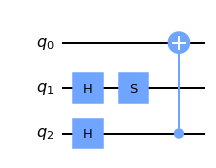

In [6]:
initial_state.construct_circuit('circuit').draw()

This state is symmetric with respect to the middle qubit. With the rotation, the ansatz becomes

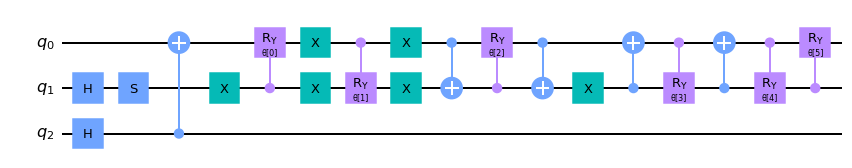

In [7]:
from qiskit.circuit import ParameterVector
var_form.construct_circuit(ParameterVector('θ', var_form.num_parameters)).draw()

Due to the symmetry of the compressed zero state, we can rotate either half of the system. For our purposes it is more convenient to rotate the upper half because this way we can compute the expectation value just by passing to Qiskit the compressed operator and treating the rest as ancillae, instead of having to provide an operator for the whole system by tensoring the compressed operator with identities.

#### Defining the operator

Let's now define the operator. A quadratic Hamiltonian can only have the following terms: Z, XX, YY, XY and YX. Moreover, the converter can only generate the compressed operator if the Hamiltonian is homogeneous (i.e all terms of any of the 5 classes have the same coefficient).

In this case we want to find the energy density of the following quadratic Hamiltonian on 2 qubits:

In [8]:
H = ((I^Z) + (Z^I)) +2*(Y^Y)

Let's compute its eigenvalue and find the energy density to compare with the value we get from the VQE.

In [9]:
energy = np.linalg.eigh(H.to_matrix())[0][0]
print(f'Energy: {energy}')
print(f'Energy density: {energy/n}')

Energy: -2.8284271247461903
Energy density: -1.4142135623730951


After compression, the Hamiltonian becomes I^Y - X^Y - Y^X (for n=2 there's no compression, the number of qubits is still 2):

In [10]:
op_reducer = QuadraticOperatorReducer()
h = op_reducer.convert(H)
print(h)

SummedOp([
  IY,
  (-1+0j) * XY,
  (-1+0j) * YX
])


By default, the converter returns the original operator's density. You can use the `density` parameter when instantiating the class to return the operator instead of its density.

#### Running the VQE

Now that we have the variational form and the compressed hamiltonian, we only need to define a classical optimizer and a quantum instance and run the VQE algorithm just as with any other eigensolver.

In [11]:
from pprint import pprint

optimizer = SPSA()

vqe = VQE(h, var_form, optimizer=optimizer, include_custom=True, quantum_instance=quantum_instance, 
          callback=print_intermediate_results(i=100))

result = vqe.run()
pprint(result)

Iteration: 100	 Energy density: -1.3970659371343173
Iteration: 200	 Energy density: -1.4071840793844321
Iteration: 300	 Energy density: -1.41222865514194
Iteration: 400	 Energy density: -1.4071885479191735
Iteration: 500	 Energy density: -1.4085194322703625
Iteration: 600	 Energy density: -1.4099985014635181
Iteration: 700	 Energy density: -1.4100976528659137
Iteration: 800	 Energy density: -1.4110757827641243
Iteration: 900	 Energy density: -1.4121259168014246
Iteration: 1000	 Energy density: -1.4140535869804476
Iteration: 1100	 Energy density: -1.4112046918621832
Iteration: 1200	 Energy density: -1.413931234625347
Iteration: 1300	 Energy density: -1.4109377878575362
Iteration: 1400	 Energy density: -1.4133313514593895
Iteration: 1500	 Energy density: -1.4105632367091392
Iteration: 1600	 Energy density: -1.4107949714835064
Iteration: 1700	 Energy density: -1.4112745921808603
Iteration: 1800	 Energy density: -1.410803251595913
Iteration: 1900	 Energy density: -1.4109398502121653
Iterat

The results are

In [12]:
print(f"Energy density (diagonalization): {energy/n}")
print(f"Energy density (VQE): {result['optimal_value']}")
print(f"Diagonalization result - VQE result: {energy/n - result['optimal_value']}")

Energy density (diagonalization): -1.4142135623730951
Energy density (VQE): -1.4142131846437012
Diagonalization result - VQE result: -3.777293939855042e-07


### 4-qubit example

Let's now do a 4-qubit example with a similar Hamiltonian.

In [13]:
n = 4

H = (I^I^I^Z) + (I^I^Z^I) + (I^Z^I^I) + (Z^I^I^I) + 2*((I^I^Y^Y) + (I^Y^Y^I) + (Y^Y^I^I))
energy = np.linalg.eigh(H.to_matrix())[0][0]
print(f'Energy: {energy}')
print(f'Energy density: {energy/n}')

Energy: -6.854068177816159
Energy density: -1.7135170444540397


In [14]:
compressed_num_qubits = int(np.log2(n) + 1)
total_num_qubits = 2*compressed_num_qubits - 1

op_reducer = QuadraticOperatorReducer()
h = op_reducer.convert(H)

initial_state = CompressedZero(total_num_qubits)
var_form = CompressedFermionicGaussianState(compressed_num_qubits, initial_state=initial_state)

optimizer = SPSA()
vqe = VQE(h, var_form, optimizer=optimizer, include_custom=True, quantum_instance=quantum_instance, 
          callback=print_intermediate_results(i=100))
result = vqe.run()

pprint(result)

Iteration: 100	 Energy density: -1.6416647443877634
Iteration: 200	 Energy density: -1.7009688620906354
Iteration: 300	 Energy density: -1.6869214191664095
Iteration: 400	 Energy density: -1.6917211988143417
Iteration: 500	 Energy density: -1.7020209413398661
Iteration: 600	 Energy density: -1.6936920496816708
Iteration: 700	 Energy density: -1.6964184546684946
Iteration: 800	 Energy density: -1.6957780806583664
Iteration: 900	 Energy density: -1.6992943798314322
Iteration: 1000	 Energy density: -1.7006981325093
Iteration: 1100	 Energy density: -1.7061111070675417
Iteration: 1200	 Energy density: -1.703561512983561
Iteration: 1300	 Energy density: -1.6938264020955163
Iteration: 1400	 Energy density: -1.697348367707021
Iteration: 1500	 Energy density: -1.701308370959442
Iteration: 1600	 Energy density: -1.7036558170390124
Iteration: 1700	 Energy density: -1.703203063716523
Iteration: 1800	 Energy density: -1.7014506517529657
Iteration: 1900	 Energy density: -1.7022108637311688
Iteration

In [15]:
print(f"Energy density (diagonalization): {energy/n}")
print(f"Energy density (VQE): {result['optimal_value']}")
print(f"Diagonalization result - VQE result: {energy/n - result['optimal_value']}")

Energy density (diagonalization): -1.7135170444540397
Energy density (VQE): -1.7105330465220012
Diagonalization result - VQE result: -0.002983997932038518


### Using the gradient

We can also compute the gradient, which may help the convergence depending on the optimizer. There are two options to evaluate the gradient within the VQE. One way is to use the custom gradient callable that can be produced in the variational form. The next section shows an example of how to use this gradient. 

The other option is using Qiskit Aqua's Gradient module, which we'll explain later.

The custom gradient callable option is recommended, as it avoids some overhead introduced by the Qiskit gradient. 

#### Custom gradient

The use of the custom gradient is very simple. You just have to create the gradient callable which will be passed to the optimizer using the `get_gradient_callable` method in the variational form object.

In [16]:
from qiskit.aqua.components.optimizers import L_BFGS_B

n = 2
compressed_num_qubits = int(np.log2(n) + 1)
total_num_qubits = 2*compressed_num_qubits - 1

H = ((I^Z) + (Z^I)) +2*(Y^Y) - 3*(X^Y)
energy = np.linalg.eigh(H.to_matrix())[0][0]
op_reducer = QuadraticOperatorReducer()
h = op_reducer.convert(H)

optimizer = L_BFGS_B()

initial_state = CompressedZero(total_num_qubits)
var_form = CompressedFermionicGaussianState(compressed_num_qubits, initial_state=initial_state)

# Create the gradient callable
gradient = var_form.get_gradient_callable(operator=h)

vqe = VQE(h, var_form, optimizer=optimizer, gradient=gradient, include_custom=True, 
          quantum_instance=quantum_instance, callback=print_intermediate_results(i=1))
result = vqe.run()
pprint(result)

Iteration: 1	 Energy density: 0.3251169355892931
Iteration: 2	 Energy density: -0.045156643499715654
Iteration: 3	 Energy density: -0.32113975406150835
Iteration: 4	 Energy density: -0.9985646586064826
Iteration: 5	 Energy density: -1.0363838914245305
Iteration: 6	 Energy density: -1.1838413875987472
Iteration: 7	 Energy density: -1.4522648655483914
Iteration: 8	 Energy density: -1.6895575106622664
Iteration: 9	 Energy density: -1.747000913887787
Iteration: 10	 Energy density: -1.7539107140571595
Iteration: 11	 Energy density: -1.7674304940987398
Iteration: 12	 Energy density: -1.7901112979292382
Iteration: 13	 Energy density: -1.8053543732097368
Iteration: 14	 Energy density: -1.8098902311724596
Iteration: 15	 Energy density: -1.8187838955093891
Iteration: 16	 Energy density: -1.8411197335250105
Iteration: 17	 Energy density: -1.8389058373857579
Iteration: 18	 Energy density: -1.858313371498332
Iteration: 19	 Energy density: -1.717460700522847
Iteration: 20	 Energy density: -1.8679708

In [17]:
print(f"Energy density (diagonalization): {energy/n}")
print(f"Energy density (VQE): {result['optimal_value']}")
print(f"Diagonalization result - VQE result: {energy/n - result['optimal_value']}")

Energy density (diagonalization): -2.0615528128088303
Energy density (VQE): -2.0615528128081673
Diagonalization result - VQE result: -6.630251903061435e-13


#### Qiskit's Gradient
Using Qiskit's Gradient has a couple of drawbracks. First, as of Qiskit 0.23.1, it doesn't work with a variational form, so we must create the quantum circuit. Since the VQE algorithm checks that the operator and the circuit have the same number of qubits, we now must tensor the compressed Hamiltonian with identities to make it a $$2\log{n} + 1$$ qubit operator.

Moreover, the operator in a VQE algorithm must be a sum of tensored operators. We have provided a converter to apply the distributive property of tensor products to any product of PauliOps or sums of PauliOps.

Finally, using Qiskit's Gradient can also be slower than using our custom gradient callable, because right now Qiskit computes the gradient circuit from the expectation value circuit once for each gradient computation, introducing an important overhead that can be avoided by creating the gradient circuit just once.

In [19]:
from cVQE.operators.converters import TensoredOpDistributor

from qiskit.circuit import ParameterVector
from qiskit.aqua.operators.gradients import Gradient
from qiskit.aqua.components.optimizers import SLSQP

n = 2
compressed_num_qubits = int(np.log2(n) + 1)
total_num_qubits = 2*compressed_num_qubits - 1

H = ((I^Z) + (Z^I)) +2*(Y^Y) - 3*(X^Y)
energy = np.linalg.eigh(H.to_matrix())[0][0]
op_reducer = QuadraticOperatorReducer()
h = op_reducer.convert(H)

optimizer = SLSQP()

initial_state = CompressedZero(total_num_qubits)
var_form = CompressedFermionicGaussianState(compressed_num_qubits, initial_state=initial_state)

# Make the compressed Hamiltonian a 2log(n) + 1 operator
h = h^(I.tensorpower(total_num_qubits - compressed_num_qubits))

# Convert h to a SummedOp operator of PauliOps
tensoredop_distributor = TensoredOpDistributor()
h = tensoredop_distributor.convert(h)

# Create the circuit from the variational form
params = ParameterVector('θ', var_form.num_parameters)
var_form_circuit = var_form.construct_circuit(params)

# Create the Gradient. The multicontrolled RY gates derivative cannot be computed with a parameter shift,
# so we must choose either the linear combination or the numerical method
gradient = Gradient(method='lin_comb')

vqe = VQE(h, var_form_circuit, optimizer=optimizer, gradient=gradient, include_custom=True, 
          quantum_instance=quantum_instance, callback=print_intermediate_results(i=1))

result = vqe.run()
pprint(result)

Iteration: 1	 Energy density: -0.012028582256096154
Iteration: 2	 Energy density: -0.8897284783752683
Iteration: 3	 Energy density: -1.1853696947030907
Iteration: 4	 Energy density: -1.7903142664804905
Iteration: 5	 Energy density: -1.9240342997549806
Iteration: 6	 Energy density: -2.0373186275527813
Iteration: 7	 Energy density: -2.056708363588946
Iteration: 8	 Energy density: -2.0488501044903162
Iteration: 9	 Energy density: -2.056487127203841
Iteration: 10	 Energy density: -2.0570635006478044
Iteration: 11	 Energy density: -2.057008050397229
Iteration: 12	 Energy density: -2.0569052866958426
Iteration: 13	 Energy density: -2.0497392476920737
Iteration: 14	 Energy density: -2.0560398168484997
Iteration: 15	 Energy density: -2.056825172770331
Iteration: 16	 Energy density: -2.0569350469956795
Iteration: 17	 Energy density: -2.05693715293909
Iteration: 18	 Energy density: -2.056925957180504
Iteration: 19	 Energy density: -2.0569171107301023
Iteration: 20	 Energy density: -2.05691172626

In [20]:
print(f"Energy density (diagonalization): {energy/n}")
print(f"Energy density (VQE): {result['optimal_value']}")
print(f"Diagonalization result - VQE result: {energy/n - result['optimal_value']}")

Energy density (diagonalization): -2.0615528128088303
Energy density (VQE): -2.0569062334631103
Diagonalization result - VQE result: -0.004646579345719992


In [21]:
import qiskit.tools.jupyter
%qiskit_version_table